In [1]:
# boiler plate
from collections import Counter
import pickle
from importlib import reload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


import ipdb
import mytf.utils as mu

tf.enable_eager_execution()

print(tf.executing_eagerly())



True


In [2]:
with open('models/2019-05-19T001217-UTC-outdata--SUBSET.pkl', 'rb') as fd:
    minidata = pickle.load(fd)
    

In [3]:
minidata.keys()

dict_keys(['x_train', 'x_test', 'y_train', 'y_test', 'y_train_original', 'y_test_original'])

In [6]:
minidata['x_train'].shape

(47689, 256, 1)

In [ ]:
# Okay let's try to add more data, but sticking to the particular 47,000 some odd
#    examples.

# (And side note, perusing through https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/ , 
# seeing that according to https://arxiv.org/abs/1804.07612 , the use of a batch size of 
#   m=32 worked across a wide range of experiments. 
#  
#  And up to several hundred is good , but as Jason Brownlee comments, this is something
#   that you simply should be tuning like any other hypermarameter.
# 
#  So I think I can try different batch sizes between m=32 and my previous m=1000)

# Also , per https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/ ,
#  standardization (-1, +1) is good practice if the input variable is Real valued and Normal . 
#  And otherwise, non-normal real valued inputs, just normalize them into (0,1 )
#  because they can help optimization converge faster and can help to avoid gradient descent
#  in getting stuck in local minima. 
# 
# And all the physiological data in this problem is most likely normal so (-1, +1) 
#  standardization it is then.

In [ ]:
# Going to add also the 
# - ecg - 3-point Electrocardiogram signal
# - and gsr - Galvanic Skin Response, "a measure of electrodermal activity. " 
#
# There is a lot more data, but I think I want to start with this.

#### Prepared some data on the side... on a shell
```python
import pandas as pd
%time df = pd.read_csv('data/sorted_train.csv')
import mytf.utils as mu

%time smalldf = mu.chomp_crews(df, crews=[1, 2], feature_cols=['r', 'gsr', 'ecg', 'eeg_t3'])

smalldf.to_csv('data/2019-07-14-crews1-2.csv') 

In [6]: %time smalldf = mu.chomp_crews(df, crews=[1, 2], feature_cols=['r', 'gsr', 'ecg', 'eeg_t3'])                                                                                    
CPU times: user 646 ms, sys: 1.1 s, total: 1.75 s
Wall time: 3.65 s
```

#### Then I quit shell and saved the chomp
```python
df = pd.read_csv('data/2019-07-14-crews1-2.csv')
```

#### Tested how long just the 'r' feature taking ... 
```python
In [18]: %%time 
    ...: outdata = mu.make_data(df, crews={'training': [1], 
    ...:                         'test': [2]}, 
    ...:               sequence_window=256, percent_of_data=1, 
    ...:              feature_cols={'r': mu.simple_scaler}) 
    ...:                                                                                        
Start building training set 2019-07-14 15:56:19 EST
Start building testing set 2019-07-14 15:56:24 EST
CPU times: user 7.6 s, sys: 4.28 s, total: 11.9 s
Wall time: 12.3 s

# 'r', 'gsr', 'ecg', 'eeg_t3'
```

#### Briefly looking at the scaling ... 
* Hmm based on the below I think I don't want to use `eeg_t3_scaled` right now , because it didn't seem to scale nicely here.
```python
ipdb> pp df.iloc[0]                                                                             
crew                    1
seat                    0
experiment             CA
time             0.183594
r                 665.002
gsr               823.356
ecg              -18260.8
eeg_t3            11.8455
event                   A
r_scaled        -0.958647
gsr_scaled        1.29753
ecg_scaled       -1.72216
eeg_t3_scaled    0.332528
Name: 0, dtype: object
ipdb> pp df.ecg_scaled.describe()                                                               
count    4.476520e+05
mean     1.478062e-16
std      1.000001e+00
min     -1.771661e+00
25%     -1.022862e+00
50%      3.681148e-01
75%      5.988211e-01
max      1.059867e+00
Name: ecg_scaled, dtype: float64
ipdb> pp df.gsr_scaled.describe()                                                               
count    4.476520e+05
mean     4.672911e-17
std      1.000001e+00
min     -1.944009e+00
25%     -7.404829e-01
50%     -2.171405e-01
75%      8.127590e-01
max      2.356093e+00
Name: gsr_scaled, dtype: float64
ipdb> pp df.r_scaled.describe()                                                                 
count    4.476520e+05
mean     2.683876e-15
std      1.000001e+00
min     -1.218953e+00
25%     -1.001033e+00
50%      9.623191e-01
75%      1.002981e+00
max      1.046743e+00
Name: r_scaled, dtype: float64
ipdb> pp df.eeg_t3_scaled.describe()                                                            
count    4.476520e+05
mean    -3.682457e-18
std      1.000001e+00
min     -3.623894e+01
25%     -2.592591e-01
50%     -2.827380e-03
75%      2.583405e-01
max      2.523465e+01
Name: eeg_t3_scaled, dtype: float64
ipdb> pp dict(df.eeg_t3_scaled.describe())                                                      
{'25%': -0.25925913610198925,
 '50%': -0.002827380336375073,
 '75%': 0.258340487132824,
 'count': 447652.0,
 'max': 25.234653756654676,
 'mean': -3.682456790014191e-18,
 'min': -36.23893554254533,
 'std': 1.0000011169409222}
```                                             

#### So even when using 1% , wow takes up a lot of space, 

```python
import pandas as pd
import mytf.utils as mu
df = pd.read_csv('data/2019-07-14-crews1-2.csv')

                                                              
df.shape                                                                 # Out[11]: (1000520, 10)
    
In [14]: %%time 
    ...: outdata = ipdb.runcall(mu.make_data, df, crews={'training': [1], 
    ...:                         'test': [2]}, 
    ...:               sequence_window=256, percent_of_data=1, 
    ...:              feature_cols=['r', 'gsr', 'ecg', ])
ipdb> c                                                                                         
Start building training set 2019-07-21 14:08:54 EST
Start building testing set 2019-07-21 14:09:16 EST
CPU times: user 30.3 s, sys: 16.2 s, total: 46.5 s
Wall time: 50.6 s


```

#### tried to pickle dump this to disk...
* I did not time it but took about 1-2 minutes..

```python
In [20]: with open('models/2019-07-21T1815-UTC-outdata-.pkl', 'wb') as fd: 
    ...:     pickle.dump(outdata, fd)
        
In [18]: outdata['x_train'].shape                                                                         
Out[18]: (446110, 256, 3)

```

* And on disk it is about `6.5G` 

```
$ ls -lh models/2019-07-21T1815-UTC-outdata-.pkl
-rw-r--r--@ 1 michal  staff   6.5G Jul 21 14:18 models/2019-07-21T1815-UTC-outdata-.pkl
$ 
```


In [5]:
# Envelope calculation ... 
# Starting with 128*(2**20) bytes
# 3x more columns 
# and (446110/47689)x more rows
# => 
128*(2**20)*3*(446110/47689)/1024/1024/1024

3.507963052276206

#### Somewhat strange. This shows I should expect 3.5G, 
* Ah okay it's because I don't have the original dfs in the minidata pkl..

```python
# In [23]: set(outdata.keys()) - set(minidata.keys())                                                       
# Out[23]: {'metadata', 'testdf', 'traindf'}
```

#### so I should try to cut it down to a random 10% ... 

```python
allindices = np.arange(0, outdata['x_train'].shape[0], 1)  

train_subset = np.random.choice(allindices, 50000, replace=False)

julydata = {
    k: outdata[k][train_subset]
    for k in {'x_test',
 'x_train',
 'y_test',
 'y_train',}
}

In [39]: {k:[outdata[k].shape, julydata[k].shape] for k in {'x_test', 
    ...:  'x_train', 
    ...:  'y_test', 
    ...:  'y_train',}}                                                                                    
Out[39]: 
{'y_train': [(446110, 4), (50000, 4)],
 'x_test': [(551326, 256, 3), (50000, 256, 3)],
 'x_train': [(446110, 256, 3), (50000, 256, 3)],
 'y_test': [(551326, 4), (50000, 4)]}



with open('models/2019-07-21T1815-UTC-outdata-SUBSET50k.pkl', 'wb') as fd:
    pickle.dump(julydata, fd)
```
* ok, on disk ...

```
-rw-r--r--@  1 michal  staff   661M Jul 21 16:32 2019-07-21T1815-UTC-outdata-SUBSET50k.pkl
```


In [8]:
import pickle

In [9]:
with open('models/2019-07-21T1815-UTC-outdata-SUBSET50k.pkl', 'rb') as fd:
    julydata = pickle.load(fd)


In [11]:
import numpy as np

In [12]:
# Look at some of these ...
# Using same approach as in earlier notebook , [2019-06-08](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-06-08-visually-inspect-generated-sequences.md)
def fetch_some_examples(array, which_col):
    gg = (i for i in np.arange(1, 50000, 1) if array['y_train'][i][which_col] == 1)
    
    return [gg.__next__() for i in range(4)]

examples = {j: fetch_some_examples(julydata, j)
               for j in range(4)}


In [13]:
examples

{0: [1, 2, 4, 6],
 1: [205, 217, 345, 379],
 2: [3, 9, 11, 12],
 3: [5, 14, 45, 51]}

In [17]:
import matplotlib.pyplot as plt
import itertools

In [21]:
julydata['x_train'][:2,:2,:]

array([[[0.9817815588300547, -0.5197607653071407, 0.5228061792048054],
        [0.9817815588300547, -0.5197607653071407, 0.5228061792048054]],

       [[0.9827723806754728, -1.657489602448204, 0.5821966747295115],
        [0.9827723806754728, -1.657489602448204, 0.5821966747295115]]],
      dtype=object)

In [44]:

def plot_col(blahdata, examples, which_col):
    x = np.arange(0, 256, 1)
    fig = plt.figure()

    for i,j in itertools.product(range(4), range(4)):
        ix = 1 + i*4 + j

        sample_row = examples[i][j]

        ax = fig.add_subplot(4, 4, ix)
        y = blahdata['x_train'][sample_row][:,which_col]
        ax.plot(x, y, color='blue')

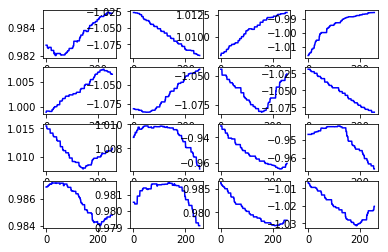

In [45]:
plot_col(julydata, examples, 0)  #  [0,1,2] => ['r', 'gsr', 'ecg', ]

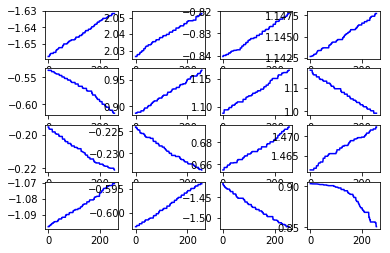

In [46]:
plot_col(julydata, examples, 1)  #  [0,1,2] => ['r', 'gsr', 'ecg', ]

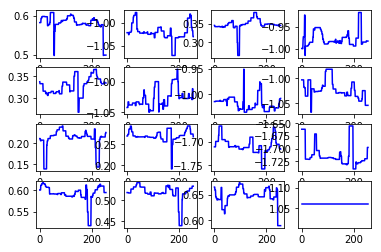

In [47]:
plot_col(julydata, examples, 2)  # [0,1,2] => ['r', 'gsr', 'ecg', ]

In [ ]:
# Ok, going to try a quick model...
